In [139]:
import json
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import wikipedia
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
from pandas.plotting import register_matplotlib_converters
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [79]:
vids = pd.read_csv('files/df_sans_zero_sentiments.csv')
#filter out outliers with not many comments (not enough comments for sentiment analysis to be robust)
for col in vids.columns[3:]:
    if str(vids[col].dtype) != 'object':
        vids = vids[(np.abs(stats.zscore(vids[col])) < 3)]
vids = vids[vids['commentCount'] > 100]
vids = vids.drop(['Unnamed: 0'],axis=1)
vids.index = pd.to_datetime(vids.date)

In [80]:
vids.columns

Index(['date', 'title', 'class', 'viewCount', 'commentCount', 'likeCount',
       'dislikeCount', 'ratio', 'magMean', 'magStd', 'magMin', 'magLq',
       'magMedian', 'magUq', 'magMax', 'sentMean', 'sentStd', 'sentMin',
       'sentLq', 'sentMedian', 'sentUq', 'sentMax'],
      dtype='object')

In [181]:
#6 equally distributed categories of likes/dislikes ratio
bin_labels = [0,1,2,3,4,5]
vids['ratio_bins'] = pd.qcut(vids['ratio'], q=6, labels = bin_labels)

In [182]:
plotting_df = vids
bin_labels = ['very low','low','medium low','medium high','high','very high']
plotting_df['ratio_bins'] = pd.qcut(plotting_df['ratio'], q=6, labels = bin_labels)

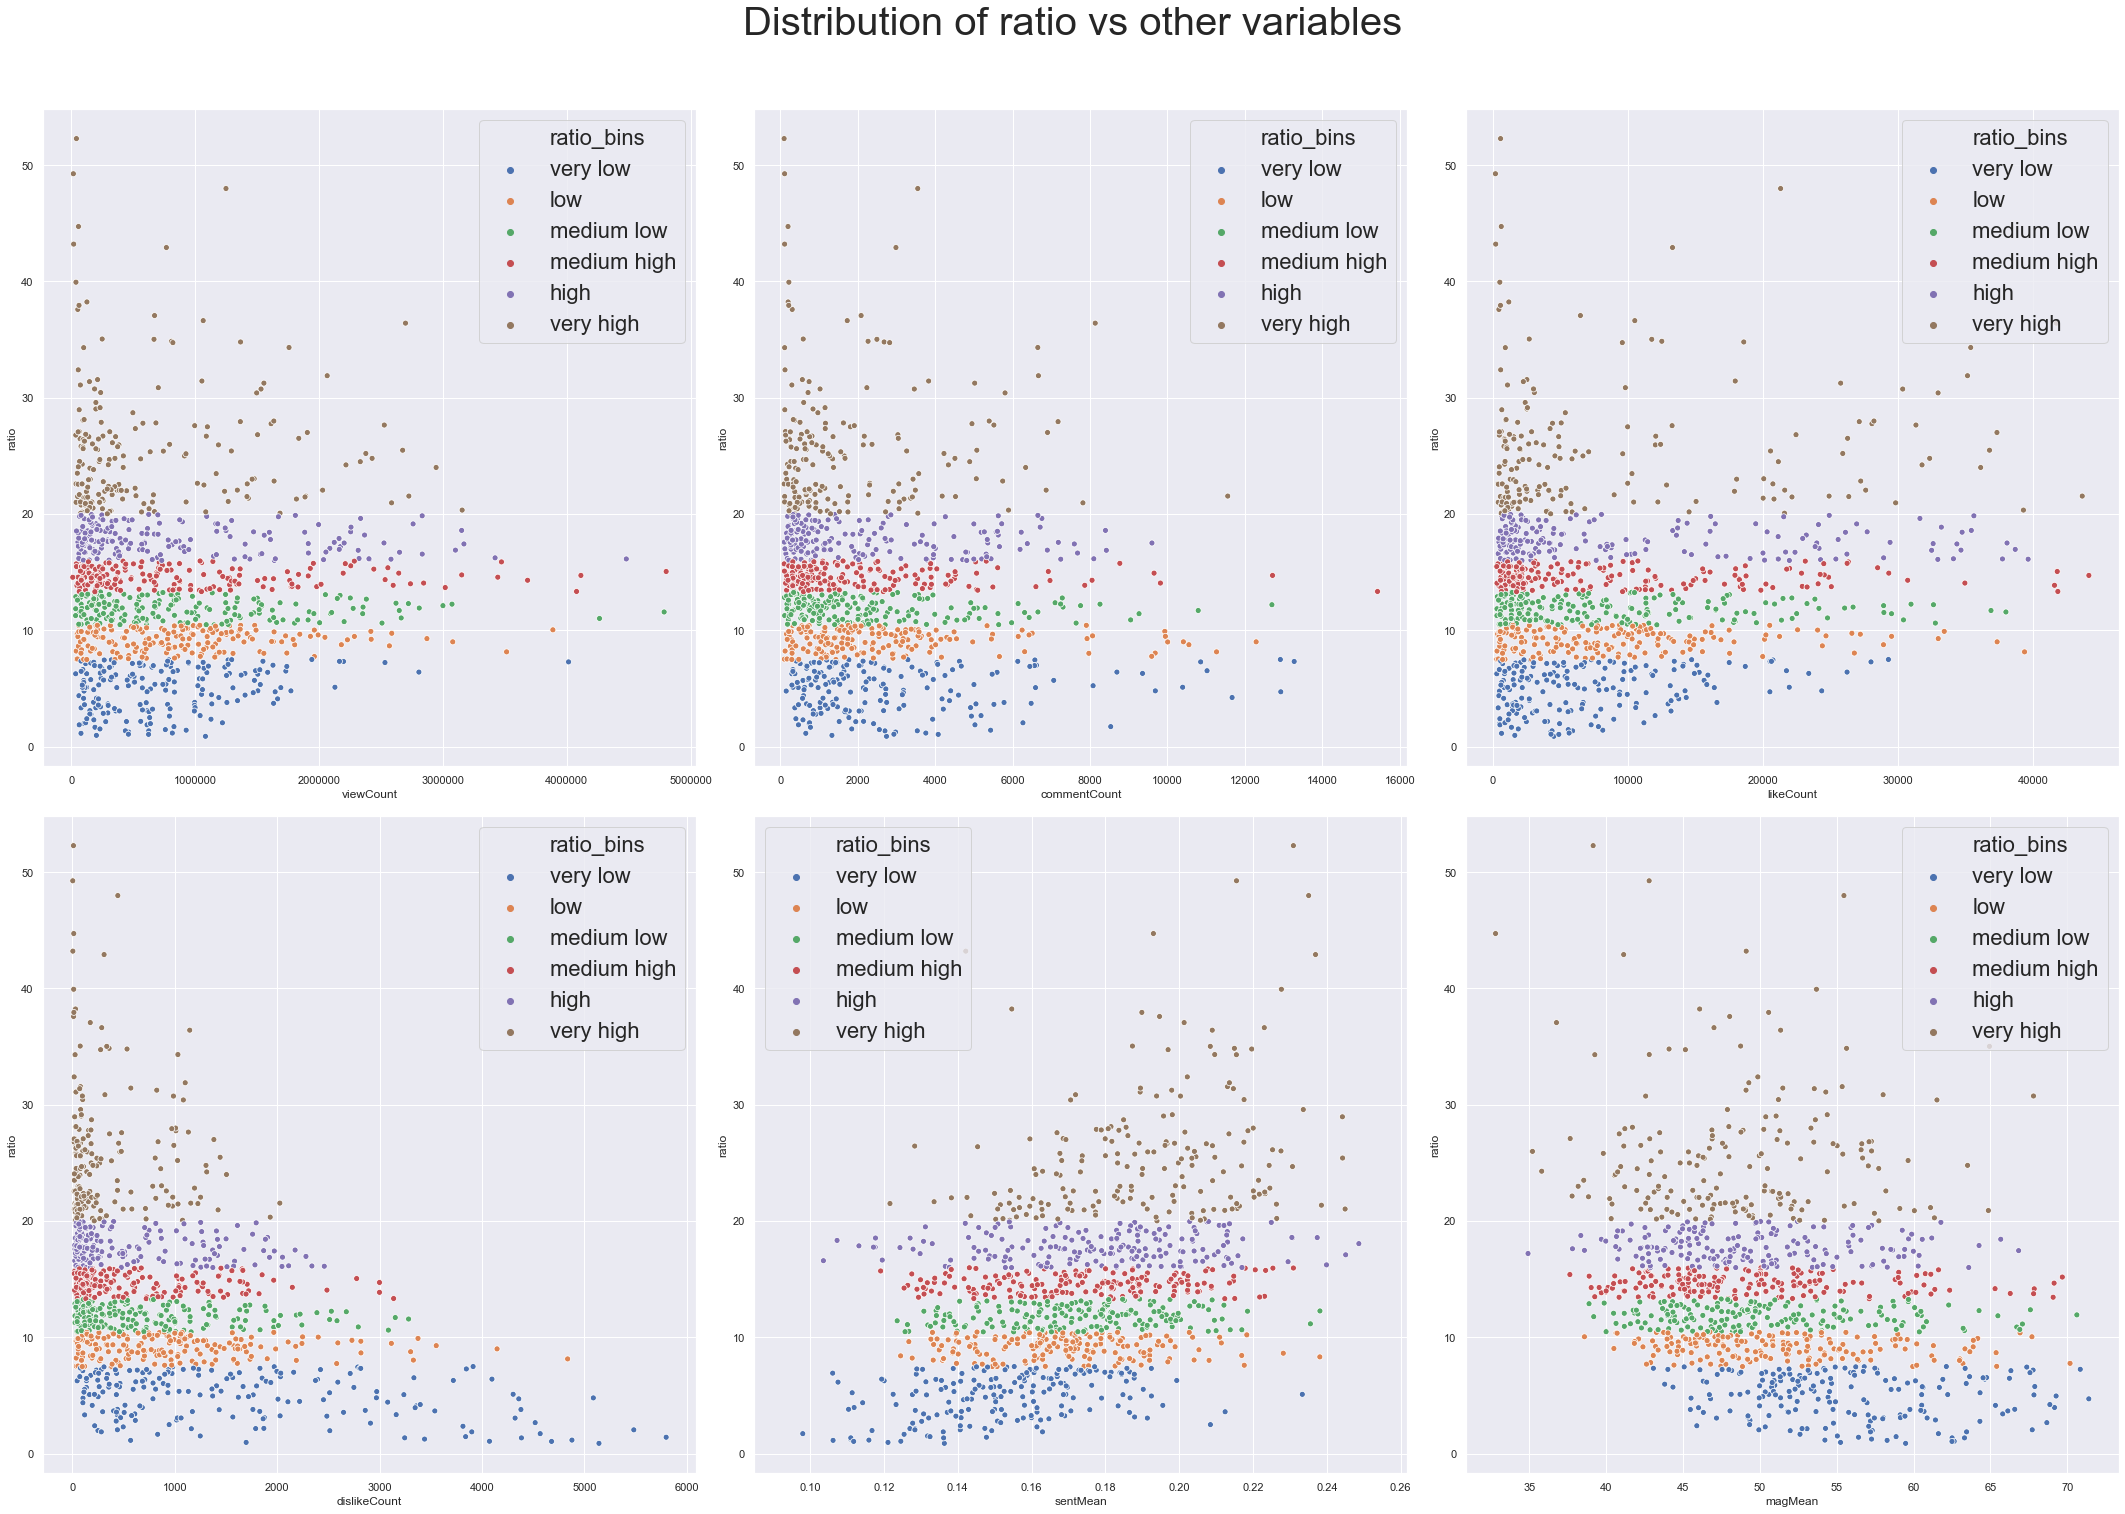

In [190]:
#basic visualisation of ratio between sentiment and ratio
fig,axes = plt.subplots(2, 3, sharex=False, sharey=False,figsize = (30,20))

cols = ['viewCount','commentCount','likeCount',
              'dislikeCount','sentMean','magMean']

fig.suptitle('Distribution of ratio vs other variables', size='40',y=1.05)
sns.set(font_scale=2)
plt.tight_layout()


for i, ax in enumerate(axes.flat):
    sns.scatterplot(data=plotting_df, x=cols[i], y="ratio", hue='ratio_bins',ax=ax)

## to do: visualisation and exploration of our data

In [84]:
vids.columns

Index(['date', 'title', 'class', 'viewCount', 'commentCount', 'likeCount',
       'dislikeCount', 'ratio', 'magMean', 'magStd', 'magMin', 'magLq',
       'magMedian', 'magUq', 'magMax', 'sentMean', 'sentStd', 'sentMin',
       'sentLq', 'sentMedian', 'sentUq', 'sentMax', 'ratio_bins'],
      dtype='object')

In [136]:
vids.head()

,date,title,class,viewCount,commentCount,likeCount,dislikeCount,ratio,magMean,magStd,...,magUq,magMax,sentMean,sentStd,sentMin,sentLq,sentMedian,sentUq,sentMax,ratio_bins
date,,,,,,,,,,,,,,,,,,,,,
2013-01-17,2013-01-17,Joe Rogan Experience #1 - Brian Redban,2,673255,2091,6485,175,37.057143,36.779625,27.964860,...,52.1150,173.46,0.201339,0.210937,-0.80,0.0925,0.22,0.3300,0.75,very high
2013-01-17,2013-01-17,Joe Rogan Experience #2 - Brian Redban,2,134693,359,1004,68,14.764706,40.918090,32.682713,...,56.8475,187.24,0.155104,0.228374,-0.64,0.0700,0.17,0.3025,0.72,high medium
2013-01-17,2013-01-17,Joe Rogan Experience #3 - Ari Shaffir,2,133176,320,1016,66,15.393939,37.651514,27.892916,...,55.4800,123.39,0.173865,0.228959,-0.67,0.0600,0.18,0.3000,0.75,high medium
2013-01-18,2013-01-18,Joe Rogan Experience #6 - Brian Redban,2,39780,104,399,19,21.000000,43.958395,34.520810,...,58.3700,224.43,0.162840,0.196018,-0.80,0.0600,0.18,0.2700,0.63,very high
2013-01-18,2013-01-18,Joe Rogan Experience #12 - Joe Rogan,2,42427,102,575,11,52.272727,39.164186,31.486648,...,54.1325,168.29,0.230930,0.234885,-0.63,0.1225,0.24,0.3400,0.79,very high


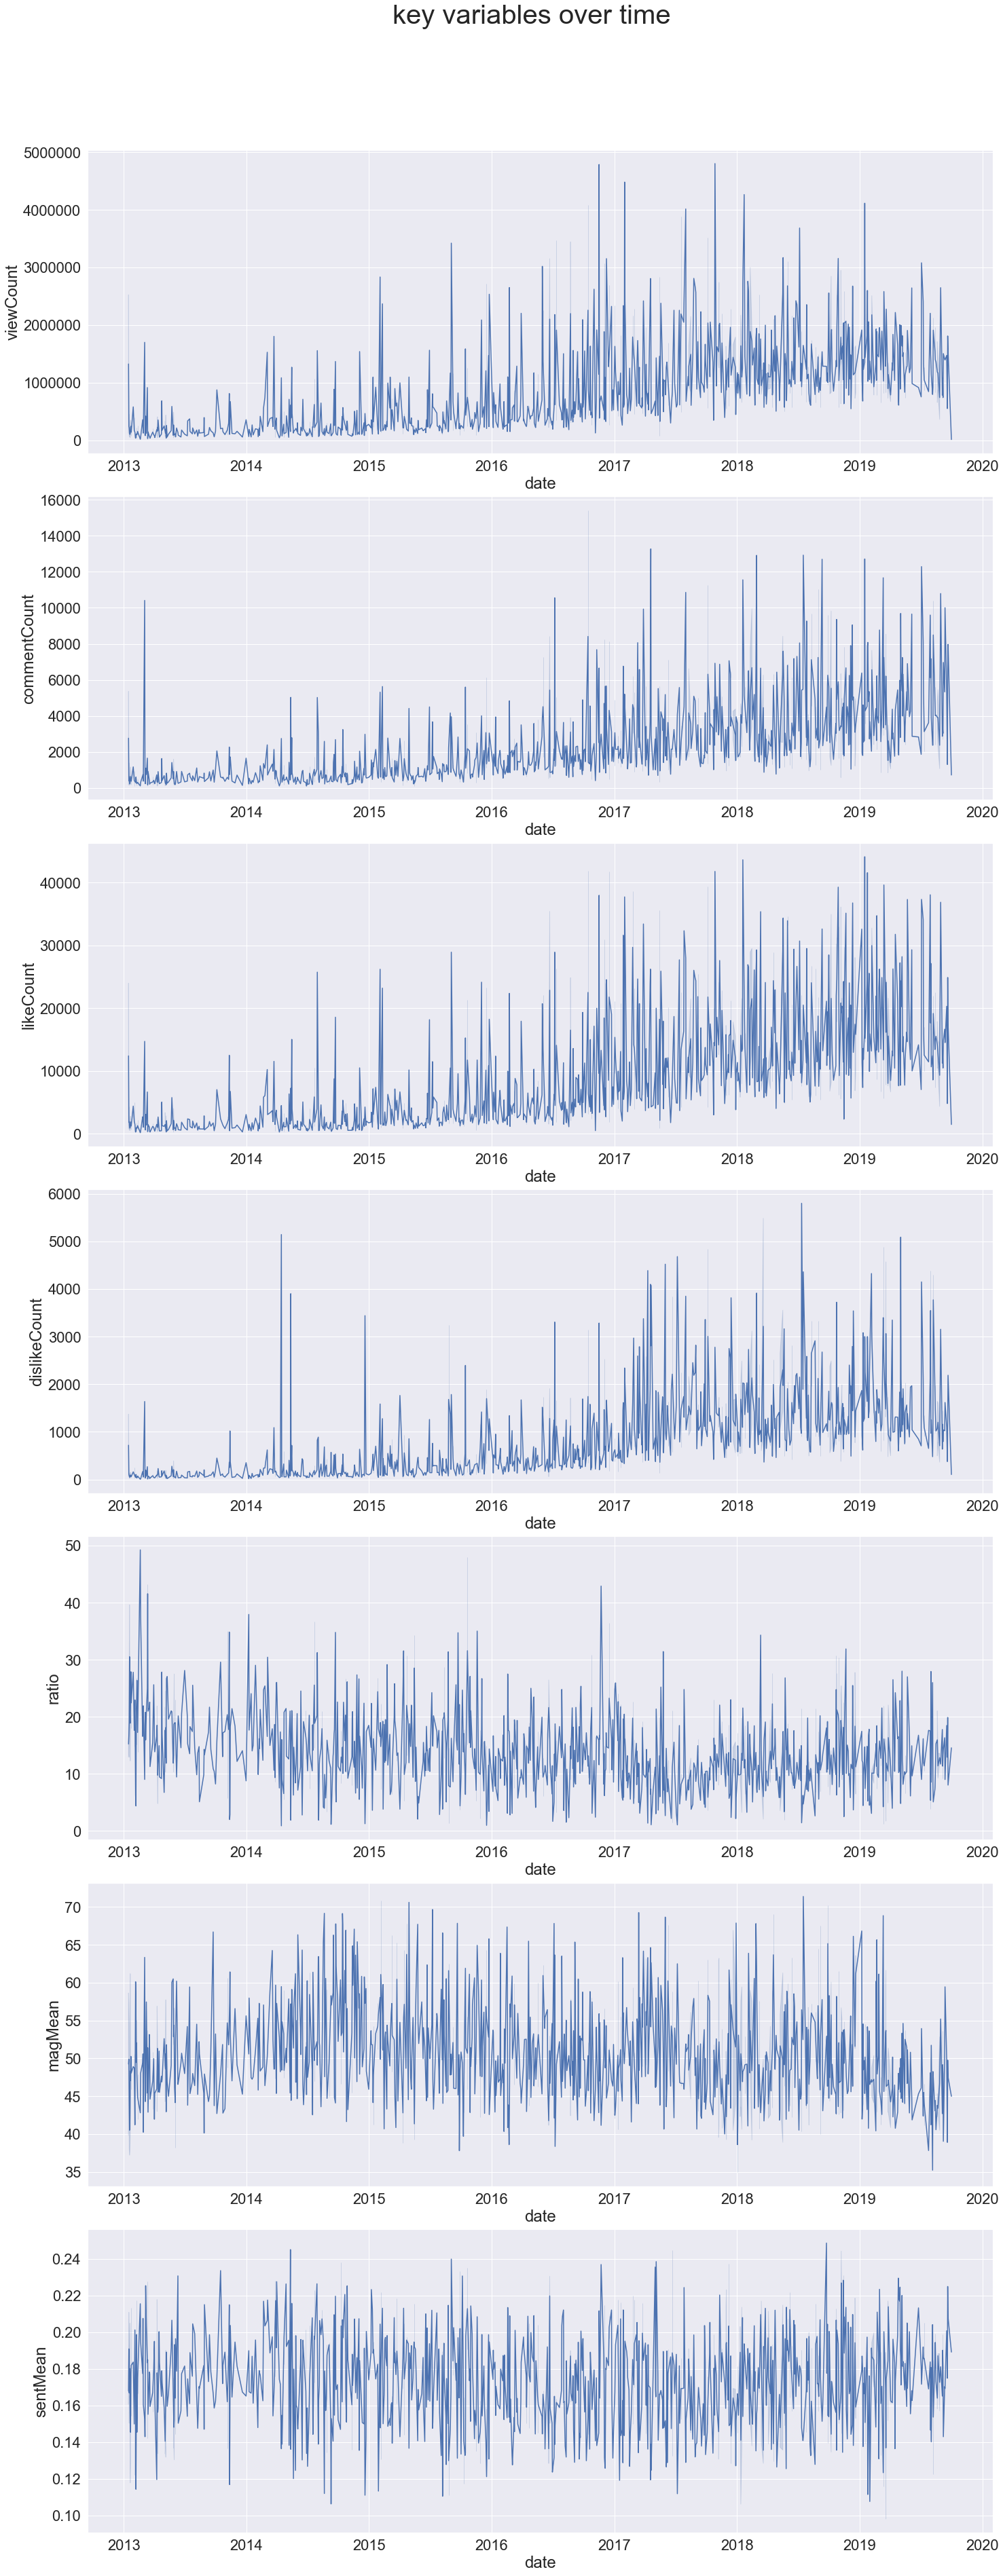

In [137]:
cols = ['viewCount','commentCount','likeCount','dislikeCount','ratio','magMean','sentMean']
titleList = ['views','comment count','likes and dislikes','ratio','magnitude mean','sentiment mean']

fig,axes = plt.subplots(len(cols), 1, sharex=False, sharey=False,figsize = (20,50))
plt.tight_layout()
fig.suptitle('key variables over time', size='40',y=1.05)
for i, ax in enumerate(axes.flat):
    sns.lineplot(data=plotting_df,x=plotting_df.index,y=cols[i],ax=ax)

In [87]:
def corr(x, y, **kwargs):
    
    coef = np.corrcoef(x, y)[0][1]
    label = str(round(coef, 2))
    
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.33), size = 50, xycoords = ax.transAxes)

In [88]:
params = ['viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'ratio', 'sentMean', 'magMean']

Text(0.5, 1.05, 'Pairgrid of key variables\n')

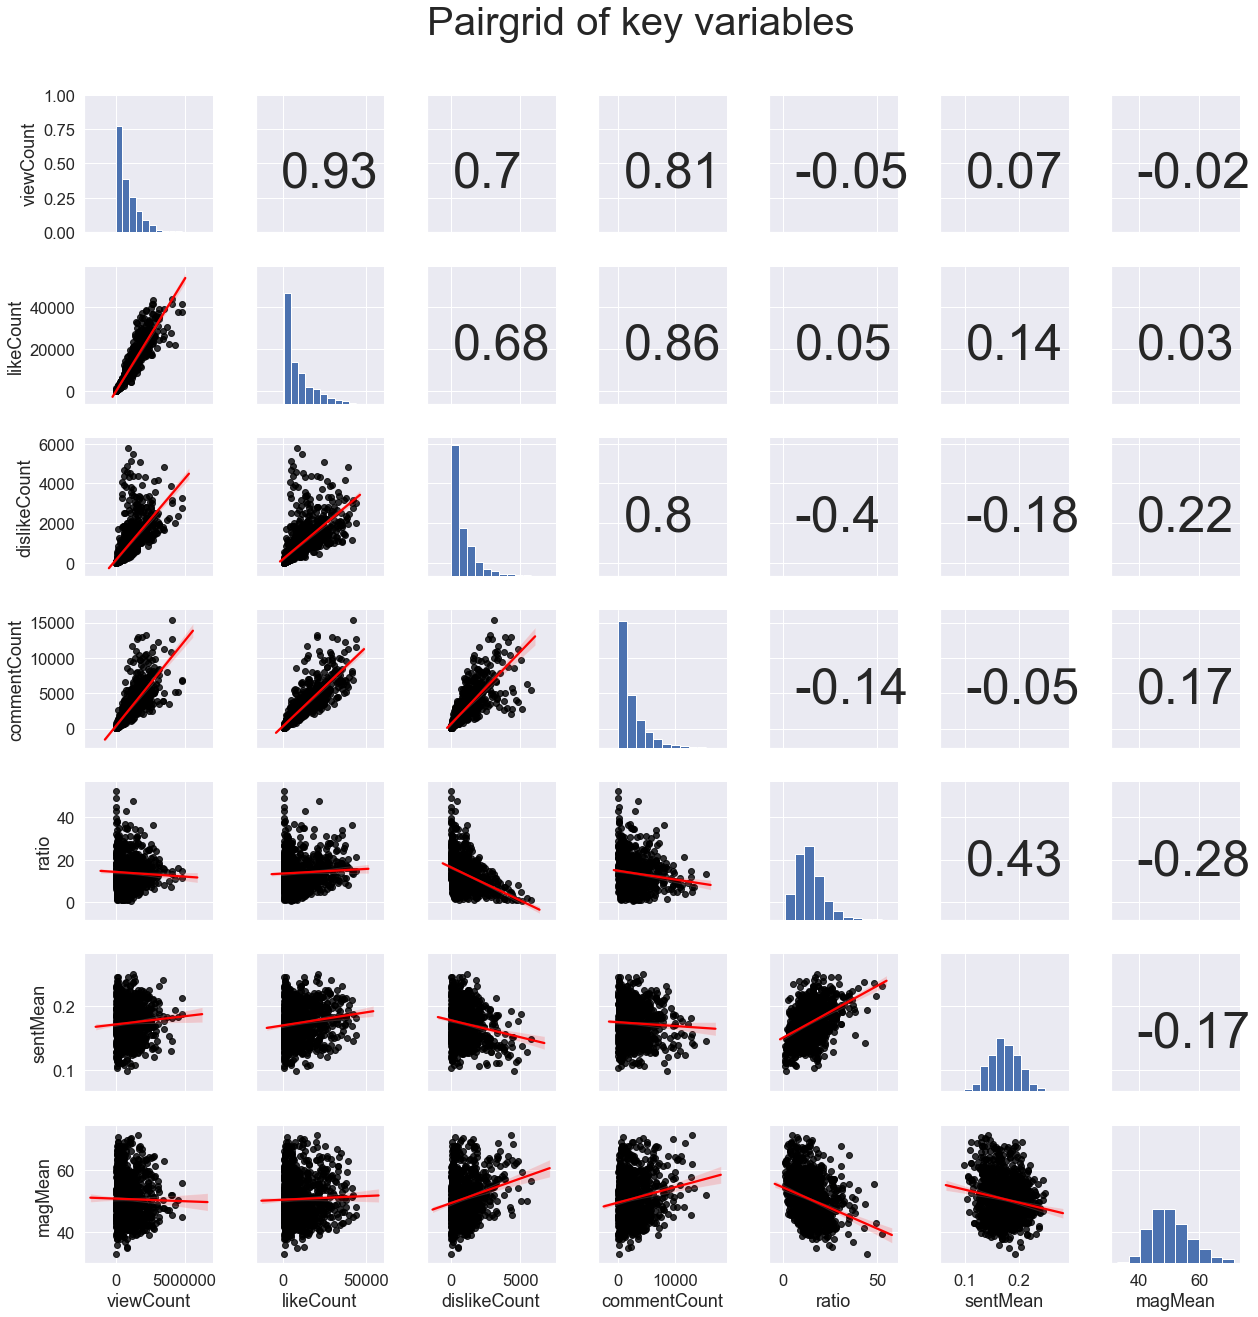

In [89]:
sns.set(font_scale=1.5)
g = sns.PairGrid(vids[params])
g = g.map_lower(sns.regplot,line_kws={"color": "red"}, scatter_kws={'color':'black'})
g = g.map_diag(plt.hist)
g = g.map_upper(corr)
plt.suptitle('Pairgrid of key variables\n',size='40', y=1.05)

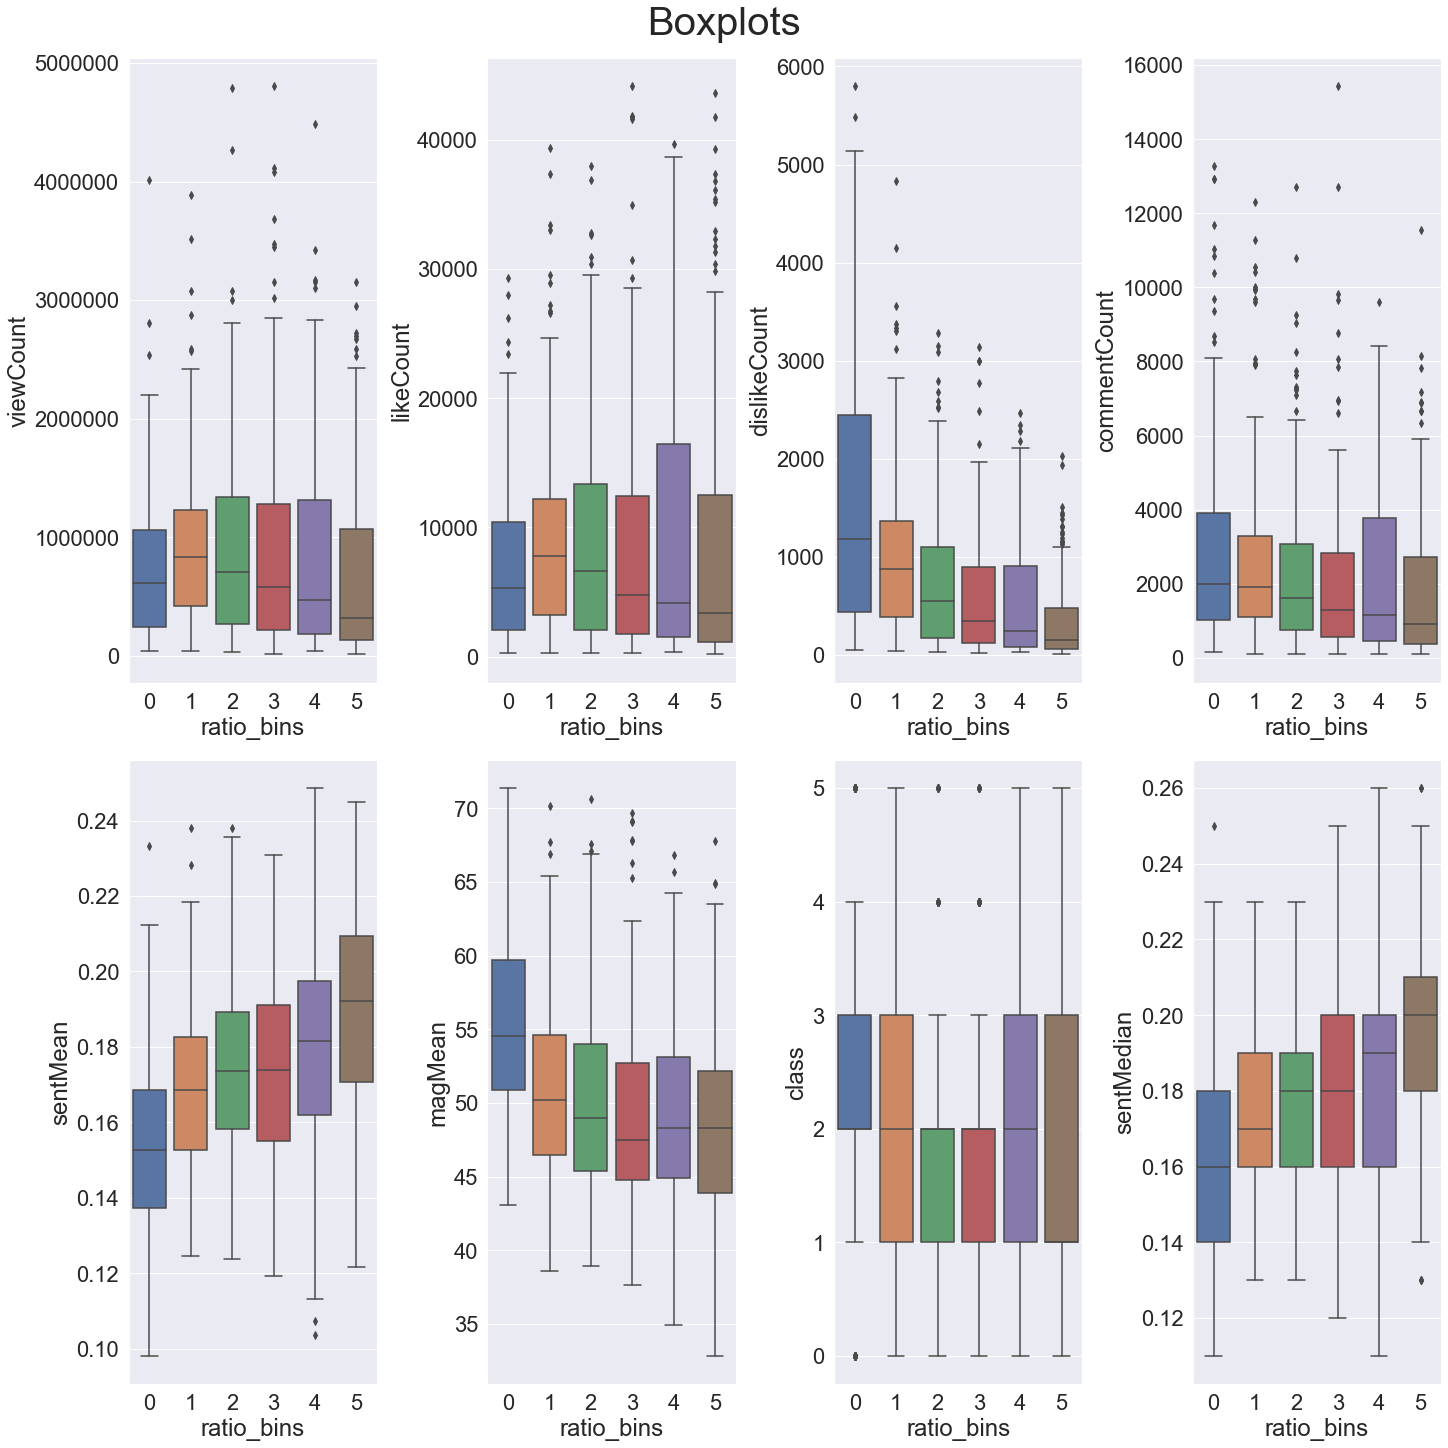

In [105]:
parameters = ['viewCount','likeCount','dislikeCount','commentCount','sentMean','magMean','class','sentMedian']
fig,axes = plt.subplots(2, 4, sharex=False, sharey=False,figsize = (20,20),constrained_layout=True)
plt.suptitle('Boxplots', size='40')
sns.set(font_scale=2)
for i, ax in enumerate(axes.flat):
    sns.boxplot(x='ratio_bins',y=parameters[i],data=vids,ax=ax)

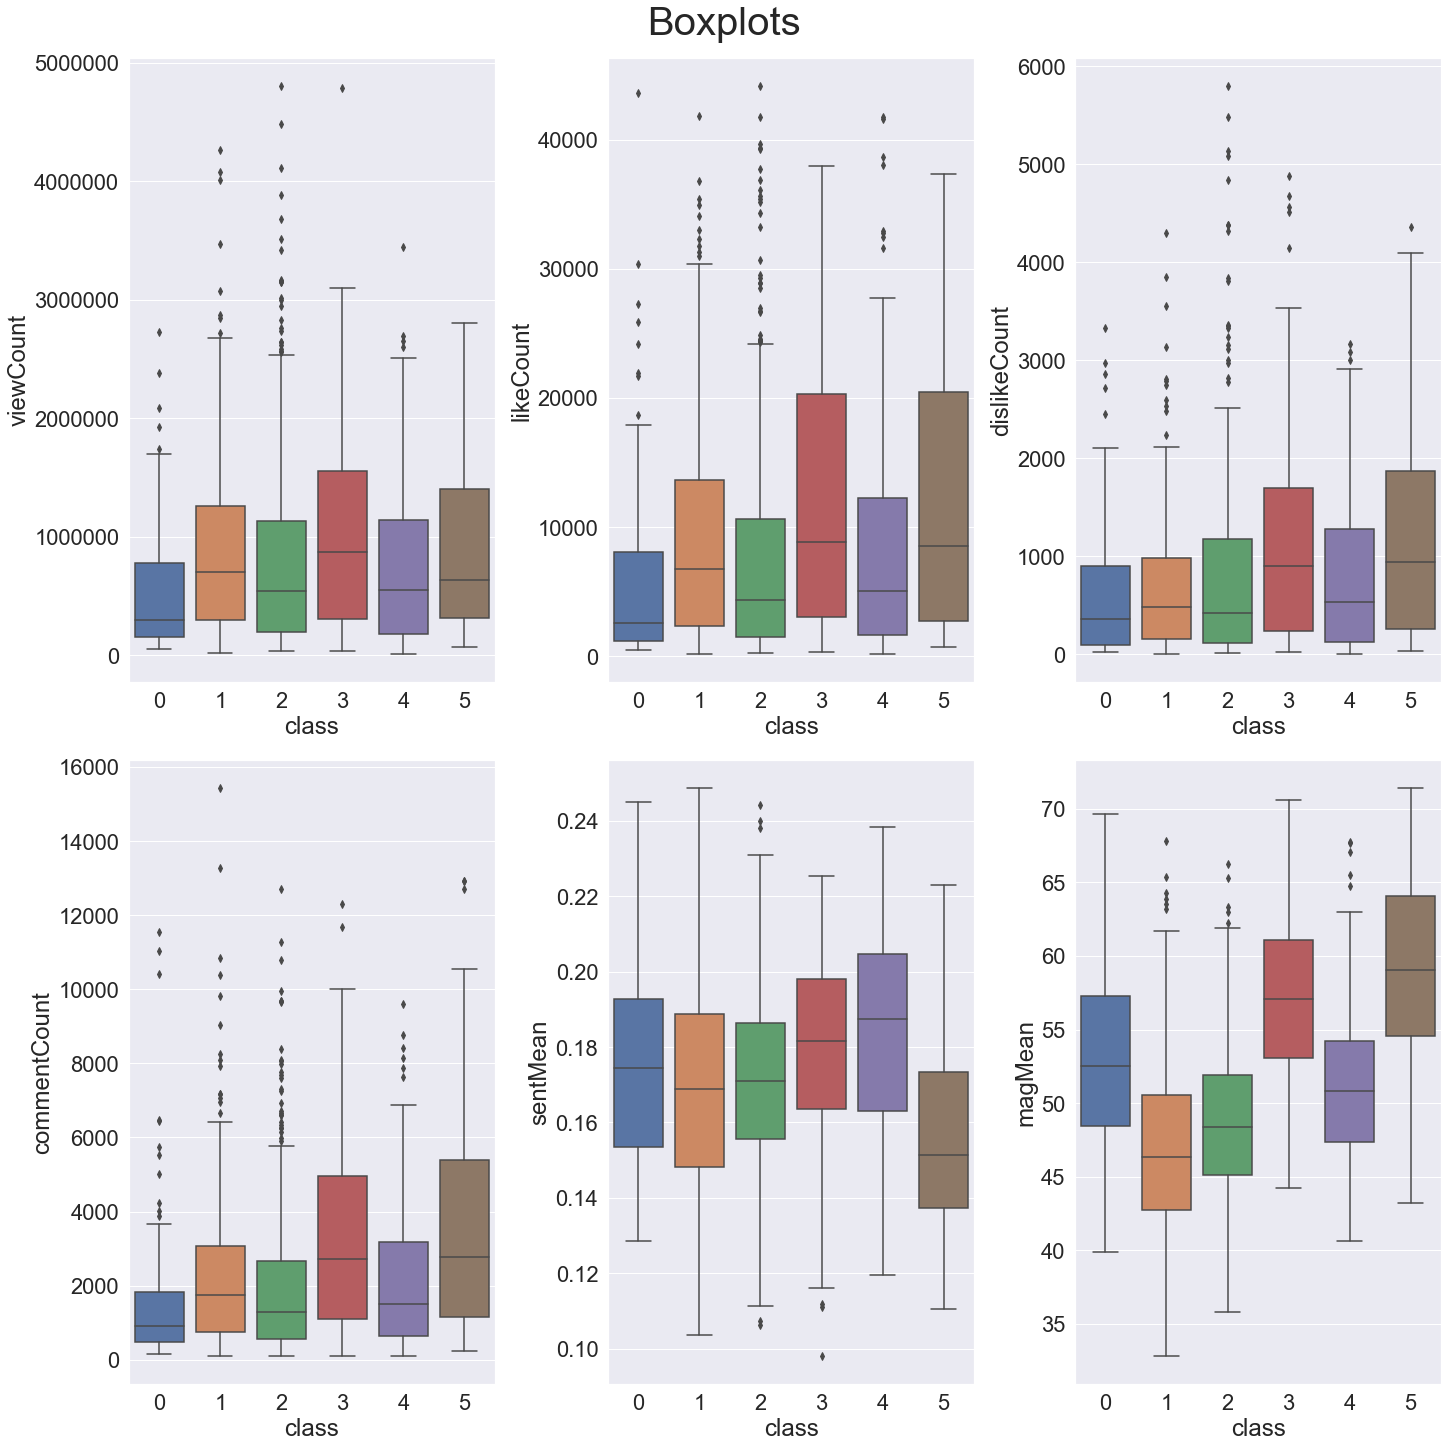

In [107]:
parameters = ['viewCount','likeCount','dislikeCount','commentCount','sentMean','magMean']
fig,axes = plt.subplots(2, 3, sharex=False, sharey=False,figsize = (20,20),constrained_layout=True)
plt.suptitle('Boxplots', size='40')
sns.set(font_scale=2)
for i, ax in enumerate(axes.flat):
    sns.boxplot(x='class',y=parameters[i],data=vids,ax=ax)

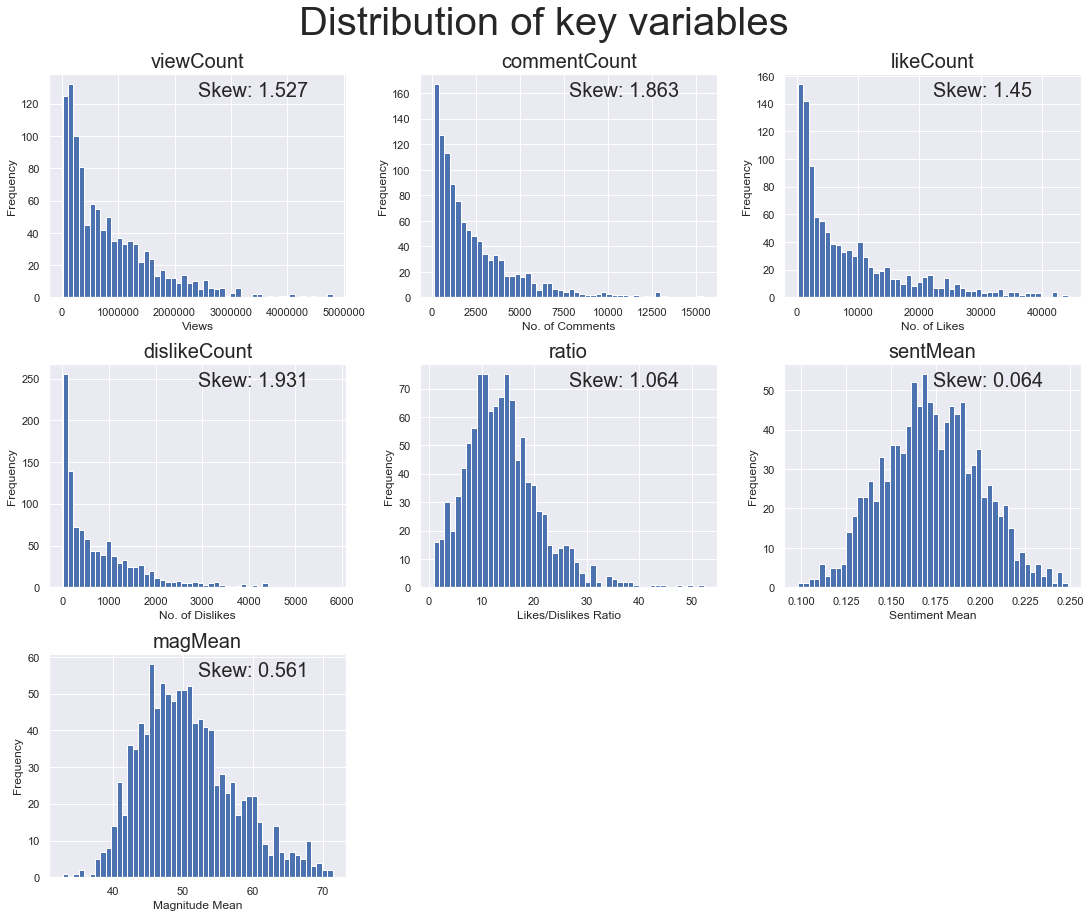

In [176]:
cols = ['viewCount','commentCount','likeCount',
              'dislikeCount','ratio','sentMean',
              'magMean']

x_label_list = ['Views','No. of Comments','No. of Likes','No. of Dislikes',
                'Likes/Dislikes Ratio','Sentiment Mean','Magnitude Mean']

fig,axes = plt.subplots(3, 3, sharex=False, sharey=False,figsize = (15,12),constrained_layout=True)
fig.suptitle('Distribution of key variables', size='40',y=1.05)
sns.set(font_scale=1)
#plt.tight_layout()
fig.delaxes(axes[2][2])
fig.delaxes(axes[2][1])


for i, ax in enumerate(axes.flat):
    if i > 6:
        break
    vids[cols[i]].hist(ax=ax,bins=50)
    skew = ('Skew: ' + str(round(vids[cols[i]].skew(),3)))
    ax.annotate(skew, xy = (0.5, 0.9), size = 20, xycoords = ax.transAxes)
    ax.set_title(cols[i], size=20)
    ax.set_xlabel(x_label_list[i])
    ax.set_ylabel('Frequency')
